# Model Klasifikasi Jenis Bunga

## Data Understanding

In [10]:
# Mendefinisikan direktori utama dataset
#dataset ini upload terlebih dulu ke drive agar bisa di load di google colab, 
#atau kalian bisa langsung download lewat kaggle langsung di google colab

import os
base_dir = 'flowers'

In [11]:
print(os.listdir(base_dir))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [12]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


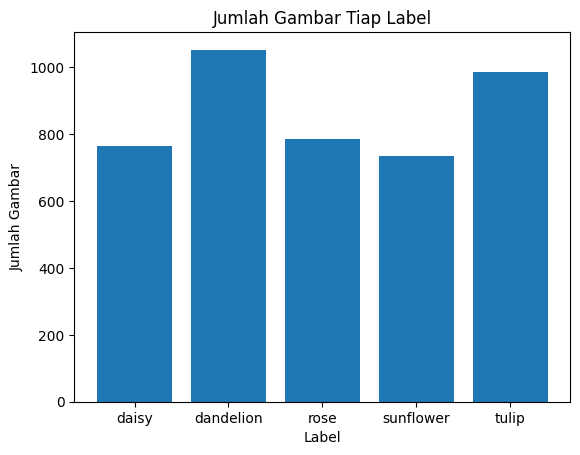

In [13]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

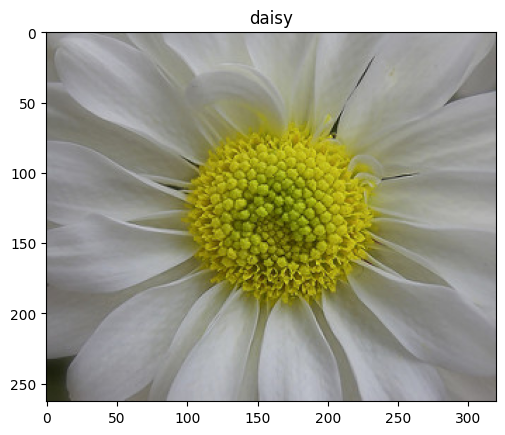

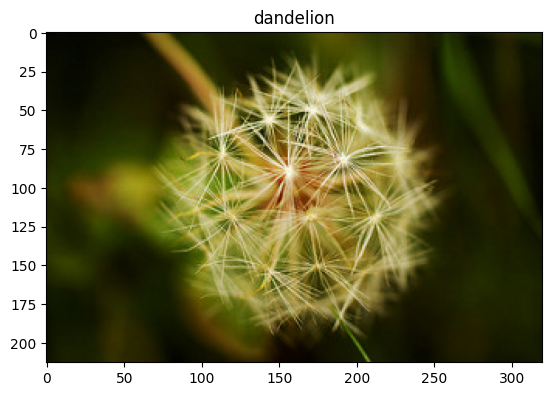

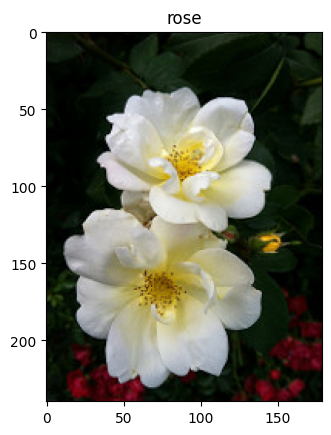

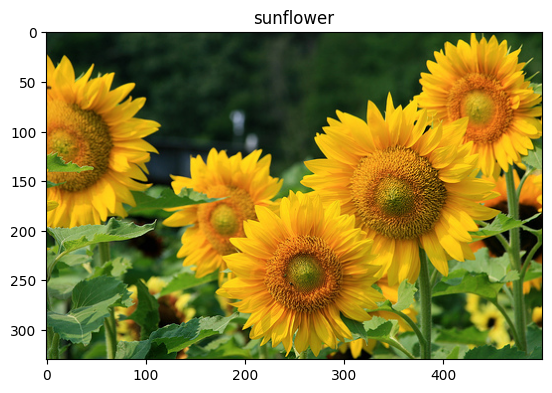

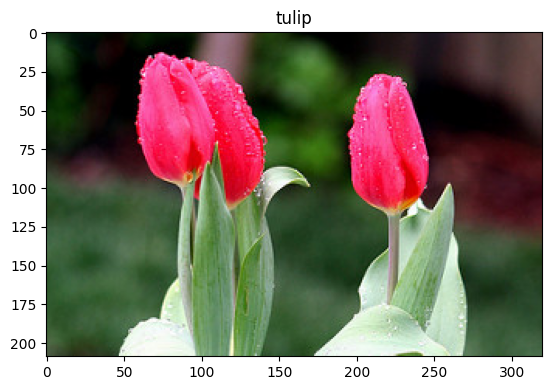

In [14]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

## Data Preparation

In [15]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [16]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [17]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [18]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

## Modelling

**Membuat Arsitektur CNN**

Penyusunan Layer

In [19]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model CNN

In [20]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 139s 1s/step - loss: 1.2794 - accuracy: 0.4330 - val_loss: 1.1220 - val_accuracy: 0.5186
Epoch 2/20
109/109 [==============================] - 95s 868ms/step - loss: 1.0718 - accuracy: 0.5606 - val_loss: 1.1814 - val_accuracy: 0.4965
Epoch 3/20
109/109 [==============================] - 95s 870ms/step - loss: 0.9746 - accuracy: 0.6130 - val_loss: 1.0180 - val_accuracy: 0.6174
Epoch 4/20
109/109 [==============================] - 94s 863ms/step - loss: 0.9093 - accuracy: 0.6445 - val_loss: 0.9535 - val_accuracy: 0.6279
Epoch 5/20
109/109 [==============================] - 115s 1s/step - loss: 0.8443 - accuracy: 0.6665 - val_loss: 0.9608 - val_accuracy: 0.6430
Epoch 6/20
109/109 [==============================] - 93s 853ms/step - loss: 0.8105 - accuracy: 0.6942 - val_loss: 0.8203 - val_accuracy: 0.6860
Epoch 7/20
109/109 [==============================] - 95s 875ms/step - loss: 0.7767 - accuracy: 0.7003 - val_loss: 0.8474 - val_accura

Evaluasi Model CNN

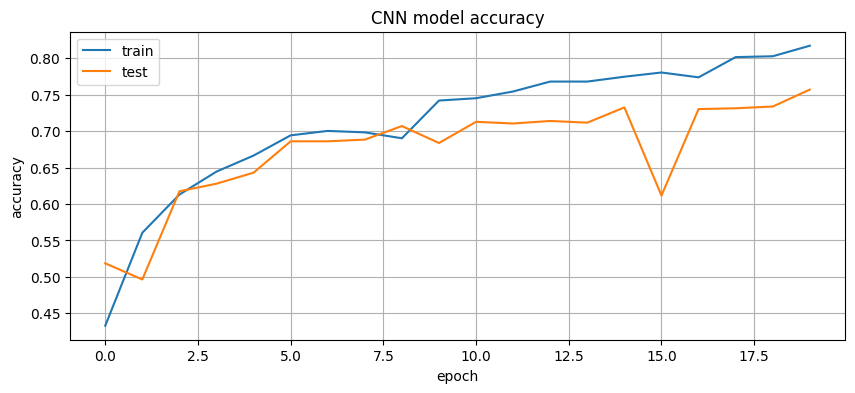

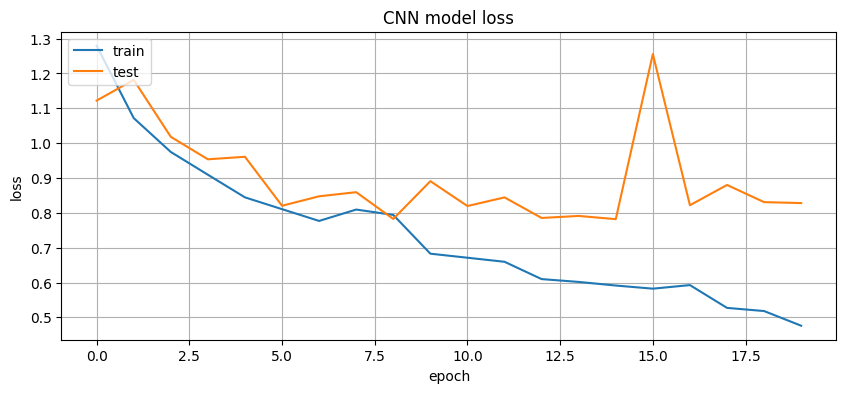

In [21]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Transfer Learning Menggunakan VGG16

Memuat Model VGG16

In [22]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

In [23]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [24]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 272s 2s/step - loss: 1.0769 - accuracy: 0.5806 - val_loss: 0.6976 - val_accuracy: 0.7547
Epoch 2/20
109/109 [==============================] - 267s 2s/step - loss: 0.7506 - accuracy: 0.7237 - val_loss: 0.6492 - val_accuracy: 0.7709
Epoch 3/20
109/109 [==============================] - 247s 2s/step - loss: 0.7155 - accuracy: 0.7350 - val_loss: 0.6859 - val_accuracy: 0.7477
Epoch 4/20
109/109 [==============================] - 249s 2s/step - loss: 0.6526 - accuracy: 0.7619 - val_loss: 0.5535 - val_accuracy: 0.7907
Epoch 5/20
109/109 [==============================] - 249s 2s/step - loss: 0.6632 - accuracy: 0.7501 - val_loss: 0.6481 - val_accuracy: 0.7605
Epoch 6/20
109/109 [==============================] - 249s 2s/step - loss: 0.6315 - accuracy: 0.7657 - val_loss: 0.5614 - val_accuracy: 0.8023
Epoch 7/20
109/109 [==============================] - 249s 2s/step - loss: 0.6277 - accuracy: 0.7671 - val_loss: 0.5192 - val_accuracy: 0.8163

Evaluasi Model

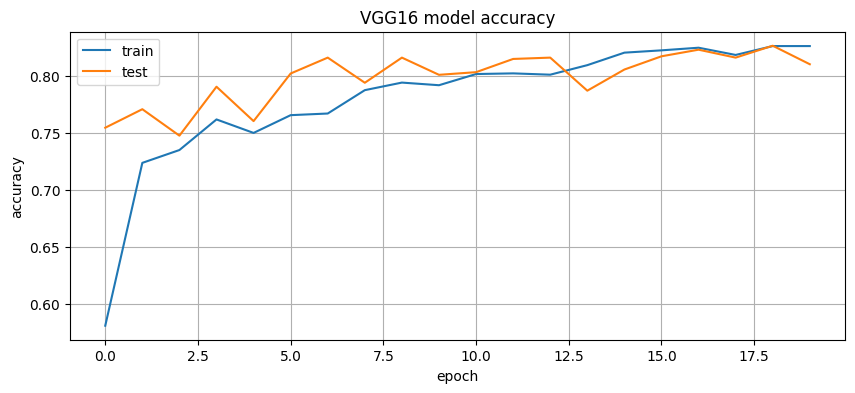

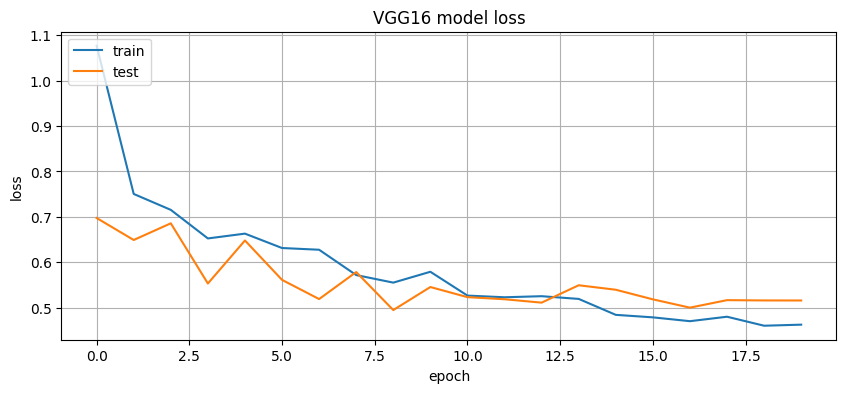

In [25]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Transfer Learning Menggunakan ResNet50

Memuat Model ResNet50

In [26]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

In [27]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [28]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 191s 2s/step - loss: 1.7648 - accuracy: 0.2655 - val_loss: 1.6244 - val_accuracy: 0.2535
Epoch 2/20
109/109 [==============================] - 187s 2s/step - loss: 1.5886 - accuracy: 0.2968 - val_loss: 1.5888 - val_accuracy: 0.2965
Epoch 3/20
109/109 [==============================] - 188s 2s/step - loss: 1.5530 - accuracy: 0.3222 - val_loss: 1.6126 - val_accuracy: 0.2500
Epoch 4/20
109/109 [==============================] - 189s 2s/step - loss: 1.5541 - accuracy: 0.3277 - val_loss: 1.4679 - val_accuracy: 0.3698
Epoch 5/20
109/109 [==============================] - 186s 2s/step - loss: 1.5373 - accuracy: 0.3263 - val_loss: 1.5198 - val_accuracy: 0.3453
Epoch 6/20
109/109 [==============================] - 186s 2s/step - loss: 1.5278 - accuracy: 0.3358 - val_loss: 1.4859 - val_accuracy: 0.3558
Epoch 7/20
109/109 [==============================] - 192s 2s/step - loss: 1.5439 - accuracy: 0.3254 - val_loss: 1.4853 - val_accuracy: 0.3884

Evaluasi Model

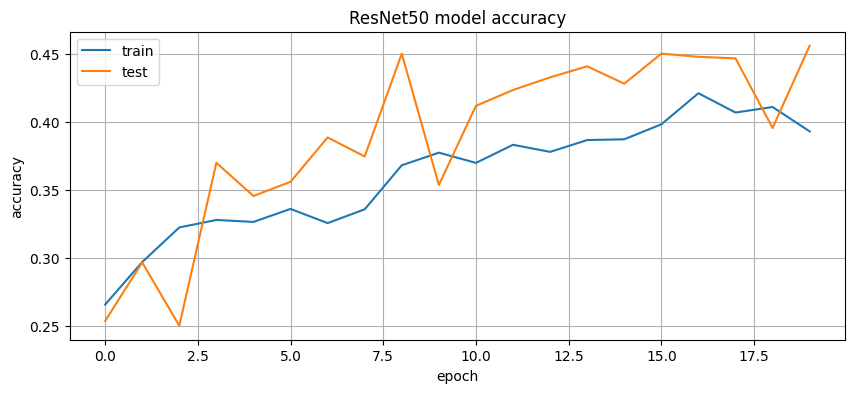

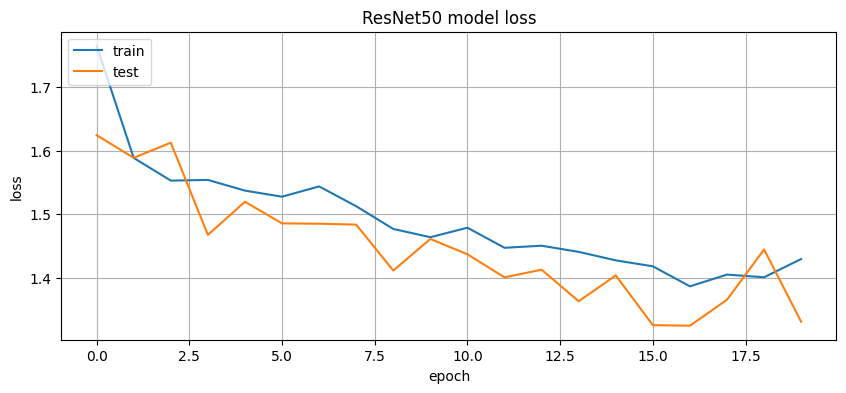

In [29]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Transfer Learning Menggunakan DenseNet201

Memuat Model DenseNet201

In [30]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

In [31]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [32]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 374s 3s/step - loss: 0.8580 - accuracy: 0.6697 - val_loss: 0.3982 - val_accuracy: 0.8570
Epoch 2/20
109/109 [==============================] - 349s 3s/step - loss: 0.5036 - accuracy: 0.8120 - val_loss: 0.4331 - val_accuracy: 0.8267
Epoch 3/20
109/109 [==============================] - 319s 3s/step - loss: 0.4161 - accuracy: 0.8470 - val_loss: 0.3868 - val_accuracy: 0.8674
Epoch 4/20
109/109 [==============================] - 330s 3s/step - loss: 0.4155 - accuracy: 0.8403 - val_loss: 0.3917 - val_accuracy: 0.8663
Epoch 5/20
109/109 [==============================] - 340s 3s/step - loss: 0.3473 - accuracy: 0.8690 - val_loss: 0.3916 - val_accuracy: 0.8767
Epoch 6/20
109/109 [==============================] - 338s 3s/step - loss: 0.3495 - accuracy: 0.8707 - val_loss: 0.3473 - val_accuracy: 0.8814
Epoch 7/20
109/109 [==============================] - 334s 3s/step - loss: 0.3407 - accuracy: 0.8704 - val_loss: 0.3309 - val_accuracy: 0.8849

Evaluasi Model

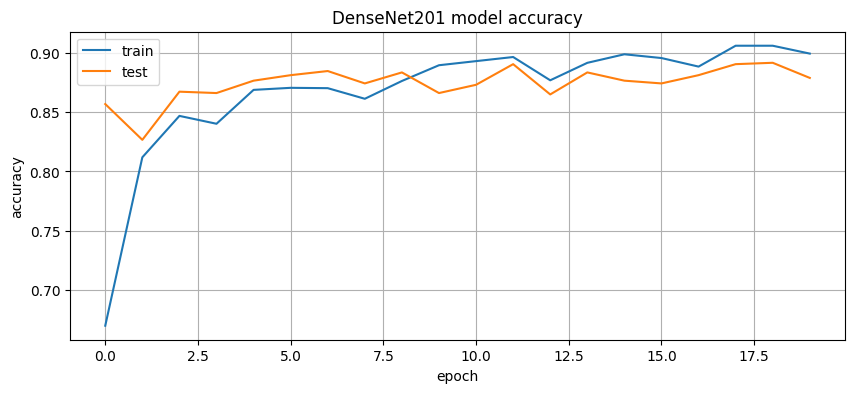

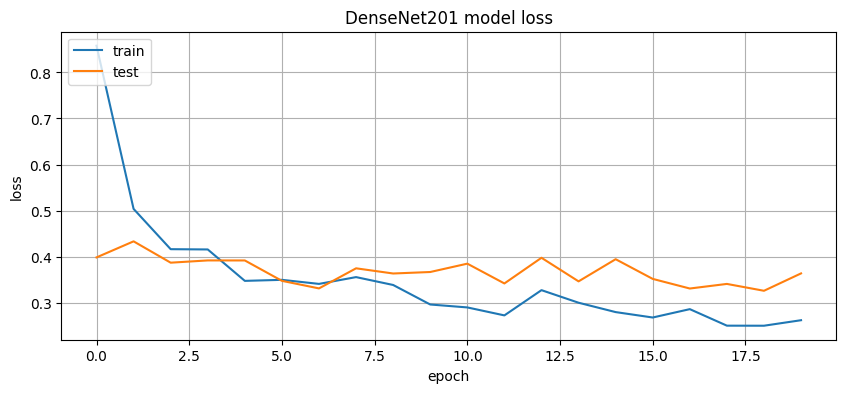

In [33]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Evaluation
Setelah membuat beberapa model, maka dapat kita bandingkan akurasi dari model-model tersebut dengan visualisasi berikut ini.

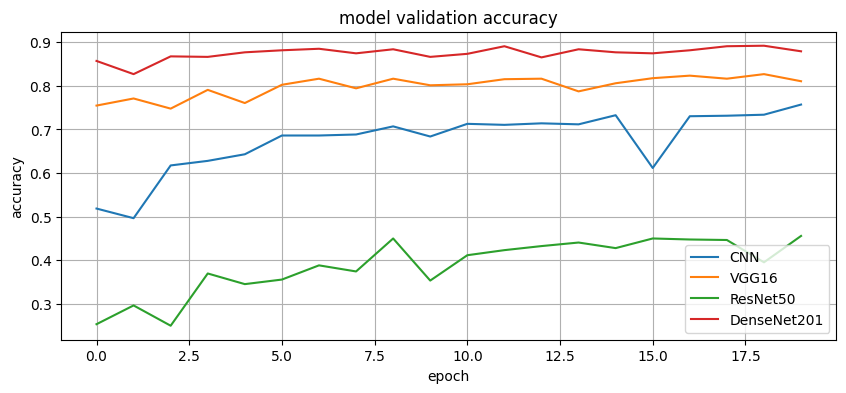

In [34]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

## Uji Coba Model

In [35]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [36]:
# Menguji coba model
import numpy as np
from keras.preprocessing import image
from google.colab import files
%matplotlib inline


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing 
#atau kalian langsung import file gambarnya langsung
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)
  
  print(fn)
  if classes==0:
    print('daisy')
  elif classes==1:
    print('dandelion')
  elif classes==2:
    print('rose')
  elif classes==3:
    print('sunflower')
  else:
    print('tulip')

ModuleNotFoundError: No module named 'google.colab'

## Deployment
Agar nantinya dapat diimplementasikan atau dikembangkan lebih lanjut, model perlu dilakukan deploy terlebih dahulu dalam format HDF5, TFLite (Mobile) atau TensorflowJS (Web)

HDF5

In [ ]:
densenet_model.save('model-flowers-recognition.h5')

TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

TensorflowJS

In [ ]:
# Instal TensorflowJS
!pip install tensorflowjs

^C


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.21.0 requires packaging>=21, but you have packaging 20.9 which is incompatible.


                                              0.0/85.1 kB ? eta -:--:--
                                              0.0/85.1 kB ? eta -:--:--
                                              0.0/85.1 kB ? eta -:--:--
     ----                                     10.2/85.1 kB ? eta -:--:--
     ----                                     10.2/85.1 kB ? eta -:--:--
     ----                                     10.2/85.1 kB ? eta -:--:--
     ------------------                     41.0/85.1 kB 245.8 kB/s eta 0:00:01
     ------------------------------------   81.9/85.1 kB 381.3 kB/s eta 0:00:01
     -------------------------------------- 85.1/85.1 kB 341.7 kB/s eta 0:00:00
                                              0.0/189.9 kB ? eta -:--:--
     --                                       10.2/189.9 kB ? eta -:--:--
     -----                                 30.7/189.9 kB 640.0 kB/s eta 0:00:01
     -----------                           61.4/189.9 kB 465.5 kB/s eta 0:00:01
     -------------

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers-recognition.h5 /content/modeltfjs

^C


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\mochf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\mochf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\mochf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\mochf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflowjs